In [ ]:
#!pip install tqdm

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_ext
import sys, os
import random

# Agregamos el path para acceder al main.py
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from main import simulate_planes
from ejercicio6 import simulate_storm_closure

In [20]:
# parametros 
lambda_prob_mc = 0.2
total_minutes = 1080   # 18 horas
N = 1000               # número de simulaciones Monte Carlo
storm_start_fixed = random.randint(0, total_minutes - 30)

Distribución (Tormenta): 100%|██████████| 1000/1000 [00:04<00:00, 227.29sim/s]


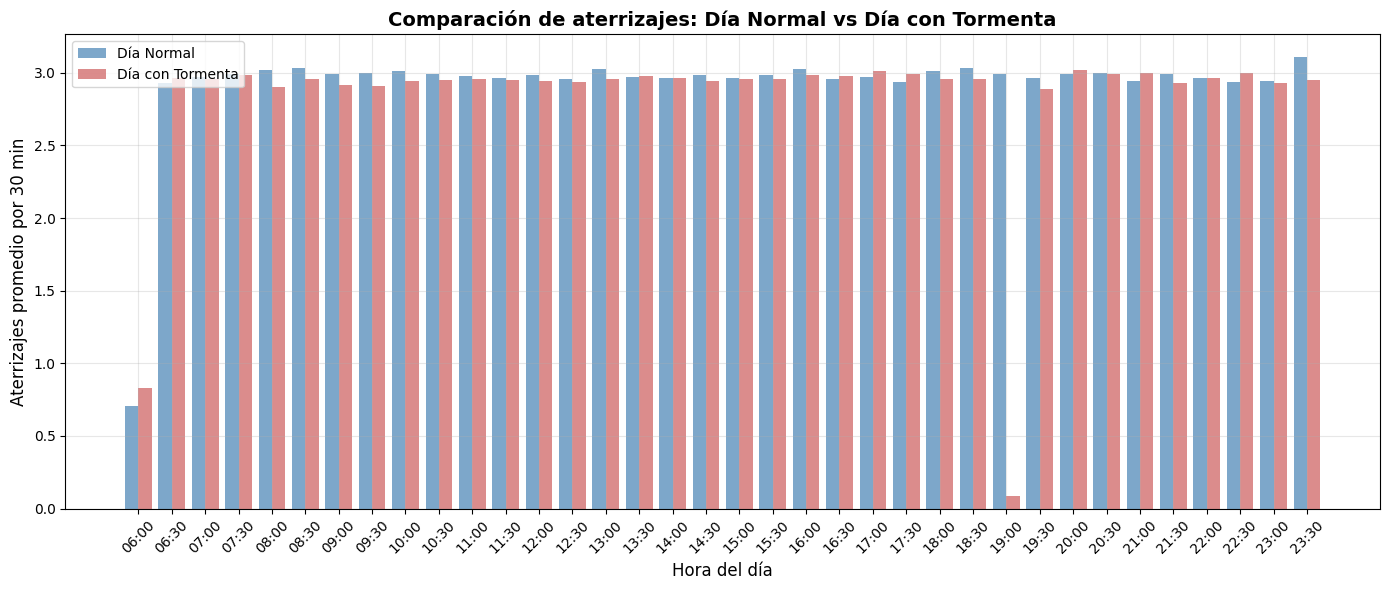

In [21]:
# Gráfico 1: Distribución de aterrizajes por intervalos de 30 min

buckets = total_minutes // 30
landings_normal_time = np.zeros(buckets)
landings_storm_time = np.zeros(buckets)

#Normal
for _ in tqdm_ext(range(N), desc="Distribución (Normal)", unit="sim"):
    planes_mc, _ = simulate_planes(lambda_prob=lambda_prob_mc, total_minutes=total_minutes)
    for p in planes_mc:
        if p.status == "landed" and p.landed_time is not None:
            bucket = min(int(p.landed_time // 30), buckets - 1)
            landings_normal_time[bucket] += 1

#Tormenta
for _ in tqdm_ext(range(N), desc="Distribución (Tormenta)", unit="sim"):
    planes_mc, landed, montevideo, afectados, tiempo_espera, max_cola, storm_start, storm_end = simulate_storm_closure(
        lambda_prob=lambda_prob_mc,
        total_minutes=total_minutes,
        storm_start=storm_start_fixed
    )
    for p in planes_mc:
        if p.status == "landed" and p.landed_time is not None:
            bucket = min(int(p.landed_time // 30), buckets - 1)
            landings_storm_time[bucket] += 1

#Promedio
landings_normal_time /= N
landings_storm_time /= N

#Gráfico
x = np.arange(buckets)
labels = [f"{6 + (i//2):02d}:{(i%2)*30:02d}" for i in range(buckets)]

plt.figure(figsize=(14, 6))
bar_width = 0.4

plt.bar(x - bar_width/2, landings_normal_time, width=bar_width, label="Día Normal", color="steelblue", alpha=0.7)
plt.bar(x + bar_width/2, landings_storm_time, width=bar_width, label="Día con Tormenta", color="indianred", alpha=0.7)

plt.xticks(x, labels, rotation=45)
plt.xlabel("Hora del día", fontsize=12)
plt.ylabel("Aterrizajes promedio por 30 min", fontsize=12)
plt.title("Comparación de aterrizajes: Día Normal vs Día con Tormenta", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

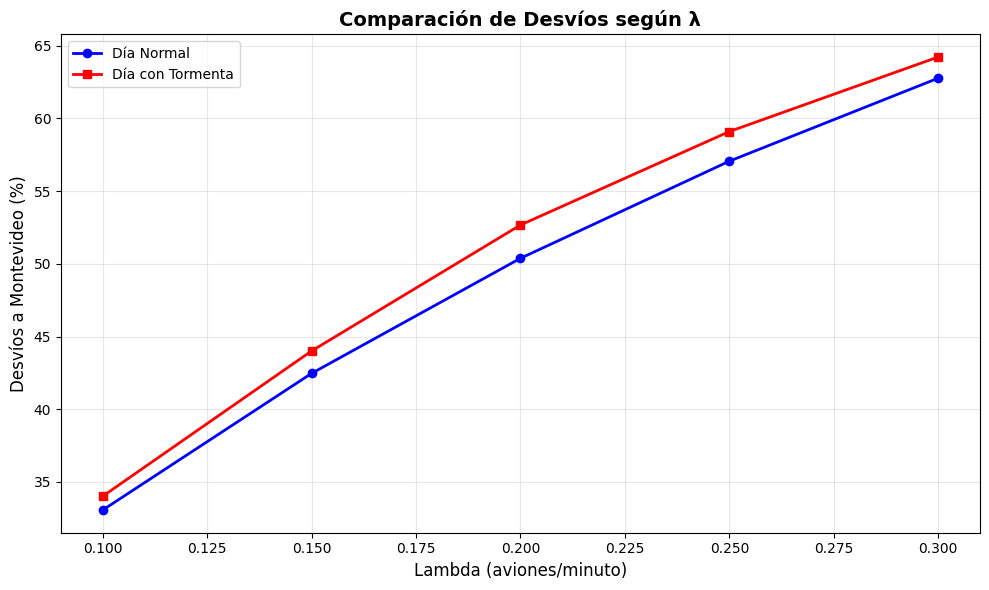

In [ ]:
#Gráfico 2: Desvíos según λ con dia normal y dia de tormenta

lambdas_test = [0.1, 0.15, 0.2, 0.25, 0.3]
desvios_prom_normal = []
desvios_prom_tormenta = []

N_lineplot = 200  # menos simulaciones por lambda para acelerar

for lam in lambdas_test:
    desvios_normal, desvios_tormenta = [], []
    
    for _ in range(N_lineplot):
        # Día normal
        planes_mc, _ = simulate_planes(lambda_prob=lam, total_minutes=total_minutes)
        landed = len([p for p in planes_mc if p.status == "landed"])
        montevideo = len([p for p in planes_mc if p.status == "montevideo"])
        total = landed + montevideo
        if total > 0:
            desvios_normal.append(montevideo / total)

        # Día con tormenta
        planes_mc, landed, montevideo, afectados, tiempo_espera, max_cola, storm_start, storm_end = simulate_storm_closure(
            lambda_prob=lam,
            total_minutes=total_minutes,
            storm_start=storm_start_fixed
        )
        total = landed + montevideo
        if total > 0:
            desvios_tormenta.append(montevideo / total)
    
    desvios_prom_normal.append(100 * np.mean(desvios_normal))
    desvios_prom_tormenta.append(100 * np.mean(desvios_tormenta))

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(lambdas_test, desvios_prom_normal, 'bo-', linewidth=2, label="Día Normal")
plt.plot(lambdas_test, desvios_prom_tormenta, 'rs-', linewidth=2, label="Día con Tormenta")

plt.xlabel("Lambda (aviones/minuto)", fontsize=12)
plt.ylabel("Desvíos a Montevideo (%)", fontsize=12)
plt.title("Comparación de Desvíos según λ", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()